# Import Libraries

In [1]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna
import pickle

# Tools

## Generating CSV File

In [2]:
def convert_to_csv(input_path: str, output_path: str) -> None:
    """
    Convert the raw Breast Cancer Wisconsin dataset into a CSV file with proper column names.

    Parameters
    ----------
    input_path : str
        Path to the raw dataset file (breast-cancer-wisconsin.data).
    output_path : str, optional
        Path where the cleaned CSV file will be saved.

    Raises
    ------
    FileNotFoundError
        If the input file does not exist.
    pd.errors.EmptyDataError
        If the input file is empty.
    Exception
        For any other unexpected errors during the CSV conversion process.
    """

    # Define dataset columns
    columns = [
        "id",
        "clump_thickness",
        "uniformity_of_cell_size",
        "uniformity_of_cell_shape",
        "marginal_adhesion",
        "single_epithelial_cell_size",
        "bare_nuclei",
        "bland_chromatin",
        "normal_nucleoli",
        "mitoses",
        "class"
    ]

    try:
        if not os.path.exists(input_path):
            raise FileNotFoundError(f"Input file not found: {input_path}")

        # Read dataset
        data = pd.read_csv(input_path, header=None)

        # Assign column names
        data.columns = columns

        # Save as cleaned CSV
        data.to_csv(output_path, index=False, header=True)
        print(f"Data successfully converted and saved to: {output_path}")

    except FileNotFoundError as e:
        print(f"Error: {e}")
    except pd.errors.EmptyDataError:
        print("Error: Input file is empty.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

## Remove Marked Rows

In [3]:
class MarkerNotFoundError(Exception):
    """Raised when the specified marker is not found in the DataFrame."""


def remove_marked_rows(df: pd.DataFrame, marker: str = '?') -> pd.DataFrame:
    """
    Remove rows from the DataFrame that contain a specific marker in any column.
    
    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame from which rows will be removed.
    marker : str, optional
        The marker indicating rows to be removed (default is '?').
        
    Returns
    -------
    pd.DataFrame
        A new DataFrame with rows containing the marker removed.
    
    Raises
    ------
    ValueError
        If the DataFrame is empty or None.
    MarkerNotFoundError
        If no rows containing the marker are found in the DataFrame.
    """
    if df is None or df.empty:
        raise ValueError("Input DataFrame is empty or None.")

    # Check if marker exists in any cell
    if not df.isin([marker]).any().any():
        raise MarkerNotFoundError(f"No rows containing marker '{marker}' were found.")

    # Remove rows with the marker (copy to avoid SettingWithCopyWarning)
    cleaned_df = df[~df.isin([marker]).any(axis=1)].copy()

    return cleaned_df

## Preview Function

In [4]:
def preview_data(df: pd.DataFrame, num_rows: int = 5) -> None:
    """
    - Display the shape of the DataFrame
    - Preview the first few rows of the DataFrame
    - Describe the DataFrame statistics
    - Display DataFrame information
    
    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to be previewed.
    num_rows : int, optional
        Number of rows to display from the top of the DataFrame (default is 5)
    """
    
    df = df.copy()
    
    print(f"📍DataFrame Shape: {df.shape}\n")
    print(f"📍First {num_rows} rows of the DataFrame:")
    display(df.head(num_rows))
    print("\n📍DataFrame Description:")
    display(df.describe(include='all'))
    print("\n📍DataFrame Info:")
    display(df.info())

# Generating CSV File

In [5]:
input_file = "./data/breast-cancer-wisconsin.data"
output_file = "./data/data.csv"
convert_to_csv(input_file, output_file)

Data successfully converted and saved to: ./data/data.csv


# Exploratory Data Analysis & Data Preprocessing

## Preview Breast Cancer Wisconsin Dataset

In [6]:
df = pd.read_csv('./data/data.csv')

preview_data(df, num_rows=10)

📍DataFrame Shape: (699, 11)

📍First 10 rows of the DataFrame:


,id,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2



📍DataFrame Description:


,id,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699,699.000000,699.000000,699.000000,699.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,402,NaN,NaN,NaN,NaN
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,NaN,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,NaN,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,NaN,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,NaN,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,NaN,5.000000,4.000000,1.000000,4.000000



📍DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           699 non-null    int64 
 1   clump_thickness              699 non-null    int64 
 2   uniformity_of_cell_size      699 non-null    int64 
 3   uniformity_of_cell_shape     699 non-null    int64 
 4   marginal_adhesion            699 non-null    int64 
 5   single_epithelial_cell_size  699 non-null    int64 
 6   bare_nuclei                  699 non-null    object
 7   bland_chromatin              699 non-null    int64 
 8   normal_nucleoli              699 non-null    int64 
 9   mitoses                      699 non-null    int64 
 10  class                        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


None

## Remove missing values ​​denoted by "?"

In [7]:
try:
    cleaned_df = remove_marked_rows(df, marker='?')
    cleaned_df['bare_nuclei'] = pd.to_numeric(cleaned_df['bare_nuclei'], errors='coerce')
    
    # 2 for benign, 4 for malignant
    # to
    # 0 for benign, 1 for malignant
    cleaned_df['class'] = cleaned_df['class'].apply(lambda x: 0 if x == 2 else 1)
    
    cleaned_df = cleaned_df.drop(columns=["id"])
    
    cleaned_df.to_csv("./data/cleaned_data.csv", index=False)
    print("Rows with '?' removed successfully.")
except MarkerNotFoundError as mnfe:
    print(mnfe)
except ValueError as ve:
    print(ve)
except Exception as e:
    print(e)

Rows with '?' removed successfully.


In [8]:
preview_data(cleaned_df, num_rows=10)

📍DataFrame Shape: (683, 10)

📍First 10 rows of the DataFrame:


,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
5,8,10,10,8,7,10,9,7,1,1
6,1,1,1,1,2,10,3,1,1,0
7,2,1,2,1,2,1,3,1,1,0
8,2,1,1,1,2,1,1,1,5,0
9,4,2,1,1,2,1,2,1,1,0



📍DataFrame Description:


,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,0.349927
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.477296
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000



📍DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 683 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   clump_thickness              683 non-null    int64
 1   uniformity_of_cell_size      683 non-null    int64
 2   uniformity_of_cell_shape     683 non-null    int64
 3   marginal_adhesion            683 non-null    int64
 4   single_epithelial_cell_size  683 non-null    int64
 5   bare_nuclei                  683 non-null    int64
 6   bland_chromatin              683 non-null    int64
 7   normal_nucleoli              683 non-null    int64
 8   mitoses                      683 non-null    int64
 9   class                        683 non-null    int64
dtypes: int64(10)
memory usage: 58.7 KB


None

## Class Distribution

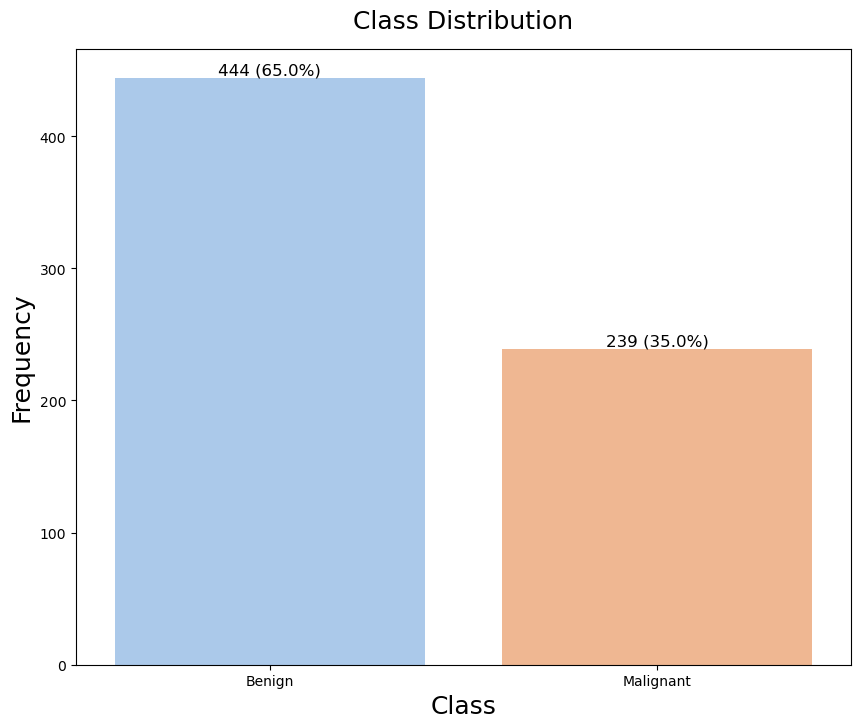

In [9]:
cleaned_df_copy = cleaned_df.copy()

# Map 0/1 to label
cleaned_df_copy['class_label'] = cleaned_df_copy['class'].map({0: "Benign", 1: "Malignant"})

# len of data
total = len(cleaned_df_copy)

plt.figure(figsize=(10, 8))
ax = sns.countplot(x="class_label", hue="class_label", data=cleaned_df_copy, palette="pastel")

# Add value above the bar
for p in ax.patches:
    count = int(p.get_height())
    percentage = 100 * count / total
    ax.annotate(f'{count} ({percentage:.1f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black')

# Visualization
plt.title("Class Distribution", fontsize=18, y=1.02)
plt.xlabel("Class", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.show()

## Distribution Visualization

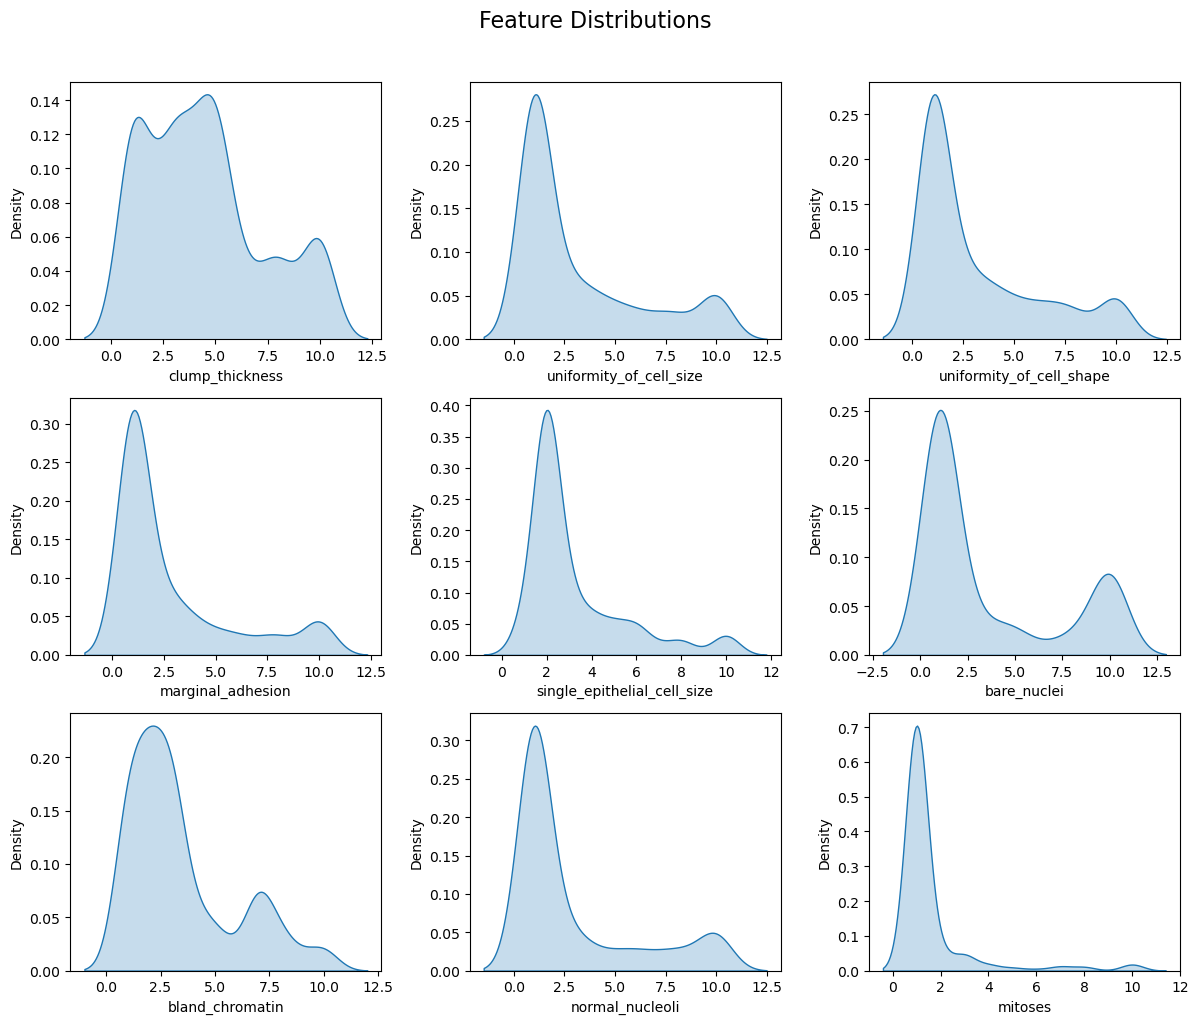

In [10]:
columns_to_visualize = [
        "clump_thickness",
        "uniformity_of_cell_size",
        "uniformity_of_cell_shape",
        "marginal_adhesion",
        "single_epithelial_cell_size",
        "bare_nuclei",
        "bland_chromatin",
        "normal_nucleoli",
        "mitoses",
    ]

# Create figure with 3 rows and 3 columns subplot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))

# Flatten so it can be looped
axes = axes.ravel()

# Create the visualization
for i, column in enumerate(columns_to_visualize):
    sns.kdeplot(cleaned_df[column], fill=True, ax=axes[i])

fig.suptitle("Feature Distributions", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Pair Plot

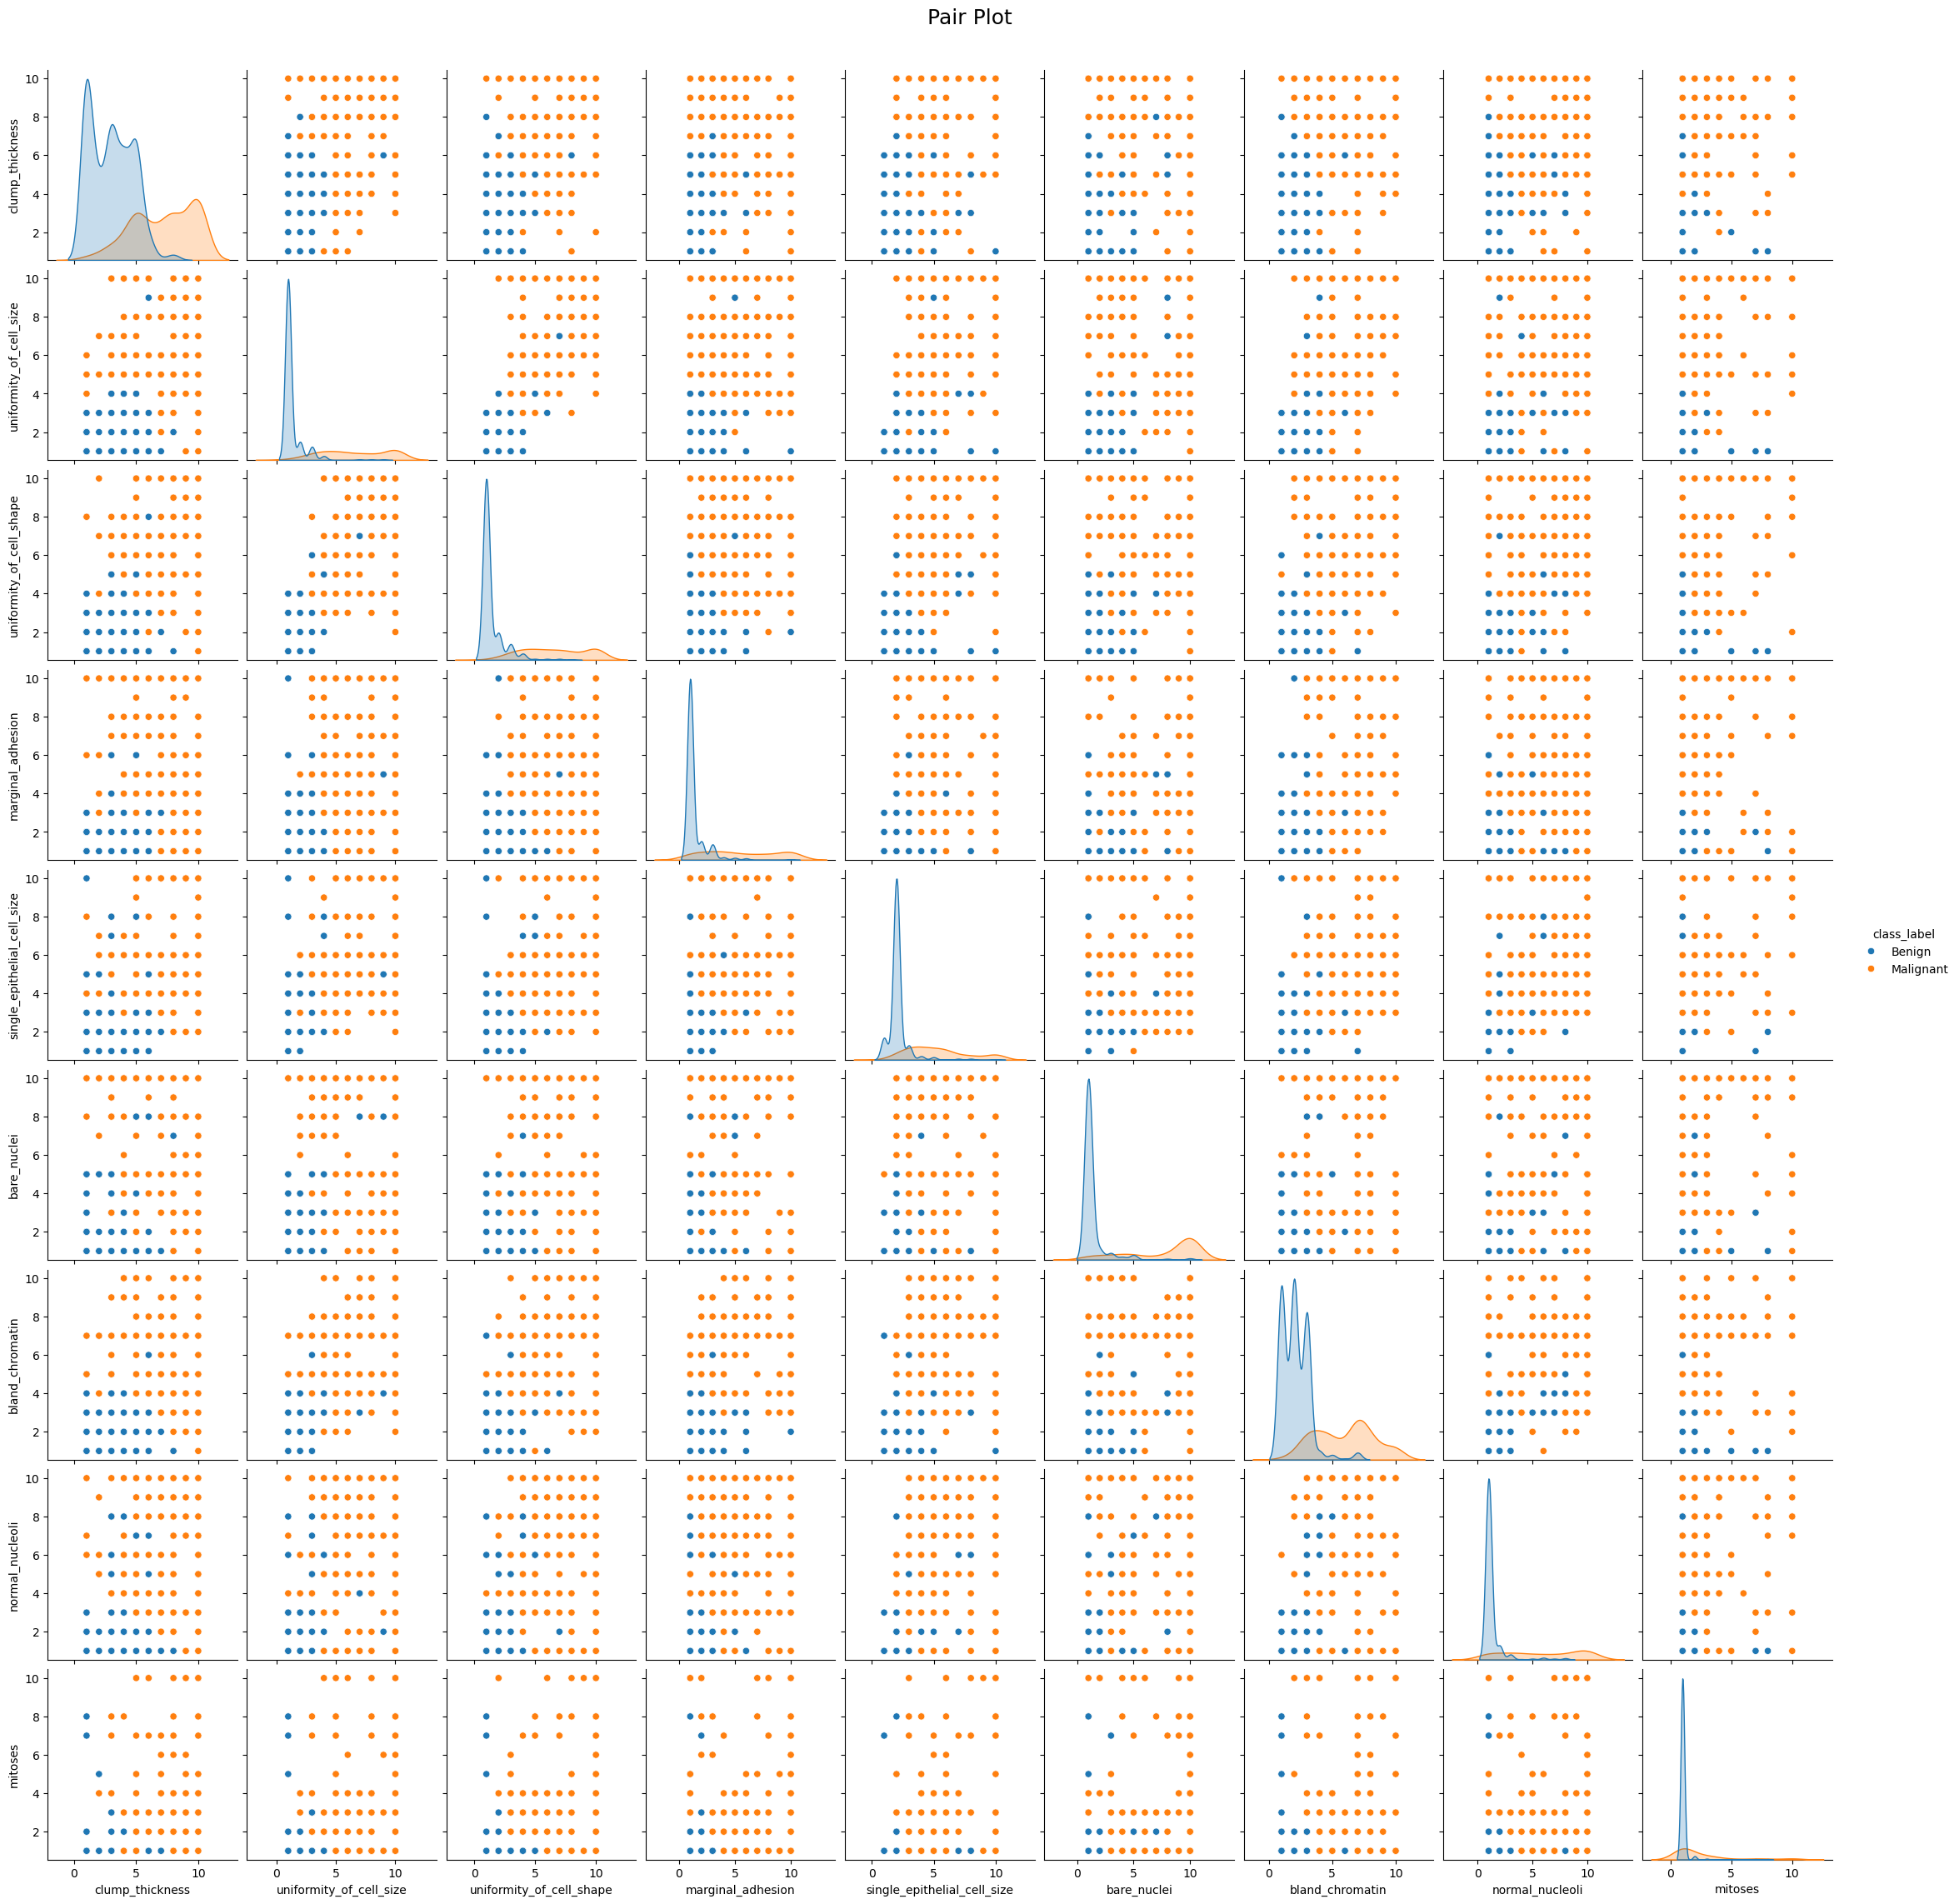

In [11]:
# Create pairplot
g = sns.pairplot(
    cleaned_df_copy[columns_to_visualize + ["class_label"]], 
    hue="class_label",
    diag_kind="kde"
)

g.figure.suptitle("Pair Plot", fontsize=18, y=1.02)
plt.show()

## Check for multicollinearity

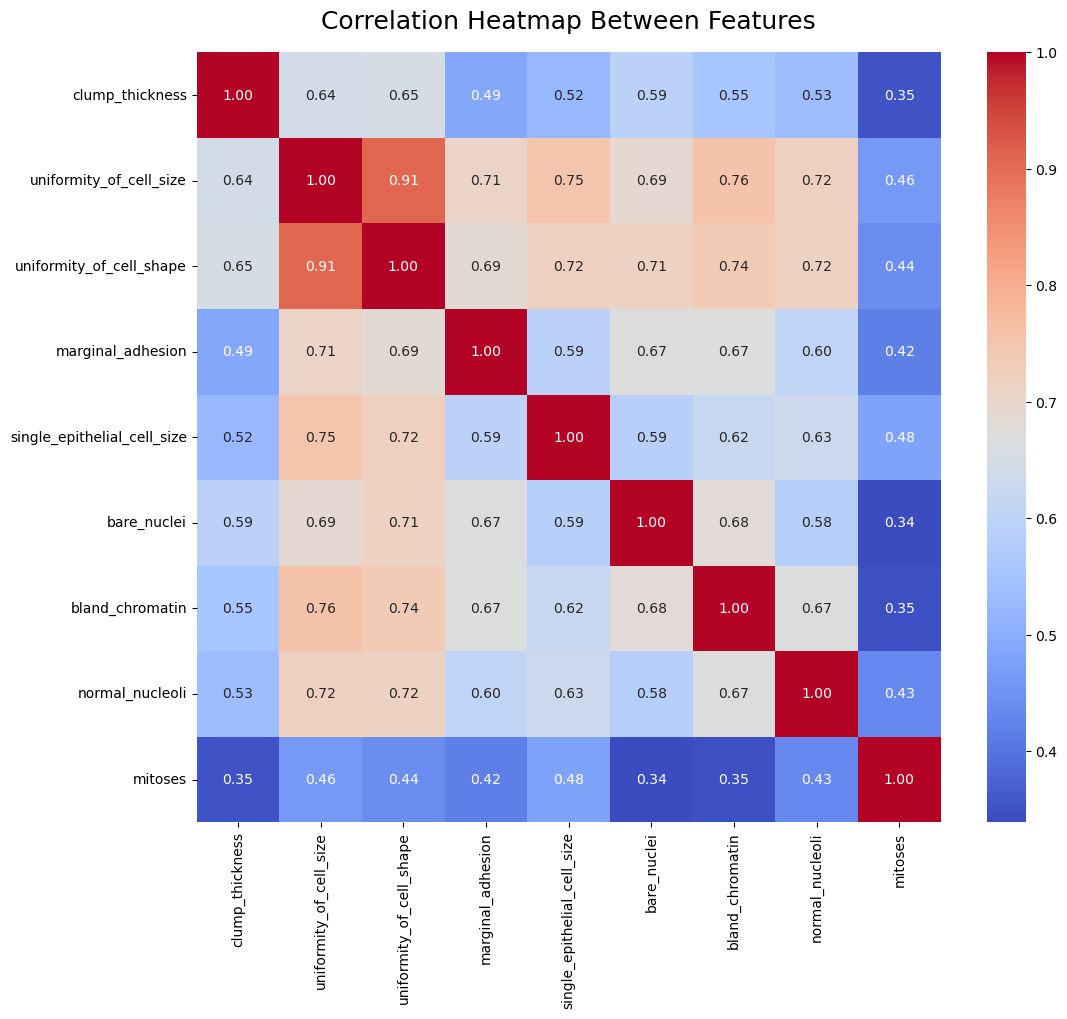

In [12]:
# Retrieve only numeric features
numeric_df = cleaned_df.drop(columns=["class"])

# Calculate the corellation
corr_matrix = numeric_df.corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Correlation Heatmap Between Features", fontsize=18, y=1.02)
plt.show()

# Modelling

## Split Dataset

In [13]:
X = cleaned_df.drop(columns=["class"])
y = cleaned_df["class"]

## Benchmarking Classification Model

In [14]:
# Model Candidates
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "KNN": KNeighborsClassifier(),
    "SVM (RBF)": SVC(kernel="rbf", probability=True, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in tqdm(models.items(), desc="Evaluating models", unit="model"):
    pipe = Pipeline([
        ("scaler", StandardScaler()),  # Important for SVM, Logistic, KNN
        ("clf", model)
    ])
    
    start = time.time()
    scores = cross_val_score(pipe, X.values, y.values, cv=skf, scoring="f1_macro")
    end = time.time()
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    elapsed_time = end - start
    
    results[name] = (mean_score, std_score, elapsed_time)

Evaluating models:  82%|████████▏ | 9/11 [00:05<00:01,  1.32model/s]c:\Anaconda\envs\bioinformatics\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Anaconda\envs\bioinformatics\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Anaconda\envs\bioinformatics\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Anaconda\envs\bioinformatics\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Anaconda\envs\bioinformatics\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names

In [15]:
# Convert to DataFrame
results_df = pd.DataFrame(results, index=["Mean F1", "Std F1", "Train Time (s)"]).T
results_df = results_df.sort_values("Mean F1", ascending=False)

print("\n===== Benchmark Results =====")
print(results_df)


===== Benchmark Results =====
                       Mean F1    Std F1  Train Time (s)
CatBoost              0.975954  0.005176        9.075402
Random Forest         0.972725  0.008337        1.732955
HistGradientBoosting  0.972613  0.011277        1.413947
XGBoost               0.967876  0.011328        0.442501
Gradient Boosting     0.967831  0.008962        1.022941
LightGBM              0.967679  0.014820        0.361154
KNN                   0.966114  0.009373        0.091366
Logistic Regression   0.966086  0.009747        0.099566
SVM (RBF)             0.964944  0.003730        0.132435
AdaBoost              0.952864  0.016851        0.686770
Decision Tree         0.943641  0.018279        0.064313


# Train CatBoost

## Hold-out Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Objective Function Optuna

In [17]:
def objective(trial: optuna.Trial) -> float:
    """
    Objective function for Optuna hyperparameter optimization of a CatBoostClassifier.

    This function defines the search space for hyperparameters, trains the model 
    using the suggested parameters, and evaluates its performance using the 
    F1-macro score on the test dataset.

    Parameters
    ----------
    trial : optuna.Trial
        A single trial of the hyperparameter optimization process, 
        which suggests a set of hyperparameters.

    Returns
    -------
    float
        The F1-macro score of the model on the test set for the current trial.
    """

    # Define the hyperparameter search space
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000),                       # Number of boosting iterations
        "depth": trial.suggest_int("depth", 3, 10),                                     # Depth of the tree
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),     # Learning rate with log scale
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),                       # L2 regularization coefficient
        "border_count": trial.suggest_int("border_count", 32, 255),                     # Number of splits for numerical features
        "random_strength": trial.suggest_float("random_strength", 0.5, 5.0),            # Randomness for score generation
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 5.0),    # Controls the intensity of Bayesian bagging
        "eval_metric": "F1",                                                            # Evaluation metric
        "random_seed": 42,                                                              # Reproducibility
        "verbose": 0                                                                    # Suppress training output
    }

    # Initialize CatBoostClassifier with the suggested hyperparameters
    model = CatBoostClassifier(**params)

    # Train the model on training data with evaluation on test data
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)

    # Predict labels for the test set
    preds = model.predict(X_test)

    # Compute F1 score (macro average for balanced importance across classes)
    score = f1_score(y_test, preds, average="macro")

    return score


## Run Optuna Study

In [18]:
# Create Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-09-16 19:12:49,810] A new study created in memory with name: no-name-9dd13349-3f1c-4a1f-b75d-f9ec19369d6b
[I 2025-09-16 19:12:50,924] Trial 0 finished with value: 0.9604617604617605 and parameters: {'iterations': 604, 'depth': 5, 'learning_rate': 0.017893094219067027, 'l2_leaf_reg': 4.4117337448499825, 'border_count': 233, 'random_strength': 4.23548661870705, 'bagging_temperature': 1.5943408502397405}. Best is trial 0 with value: 0.9604617604617605.
[I 2025-09-16 19:12:52,164] Trial 1 finished with value: 0.9685057471264368 and parameters: {'iterations': 758, 'depth': 3, 'learning_rate': 0.007132740627752418, 'l2_leaf_reg': 1.5087781433195535, 'border_count': 35, 'random_strength': 0.6574416996578232, 'bagging_temperature': 0.2221022480158913}. Best is trial 1 with value: 0.9685057471264368.
[I 2025-09-16 19:12:52,646] Trial 2 finished with value: 0.9604617604617605 and parameters: {'iterations': 226, 'depth': 6, 'learning_rate': 0.009566152889643187, 'l2_leaf_reg': 8.872465287

In [19]:
print("📍Best Params:", study.best_params)
print("📍Best F1 Score:", study.best_value)

📍Best Params: {'iterations': 758, 'depth': 3, 'learning_rate': 0.007132740627752418, 'l2_leaf_reg': 1.5087781433195535, 'border_count': 35, 'random_strength': 0.6574416996578232, 'bagging_temperature': 0.2221022480158913}
📍Best F1 Score: 0.9685057471264368


## Train Best Model

In [20]:
best_model = CatBoostClassifier(**study.best_params, random_seed=42, verbose=0)
best_model.fit(X_train, y_train)

save_path = "./data/catboost_best_model.pkl"
with open(save_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"Model successfully saved to {save_path}")

Model successfully saved to ./data/catboost_best_model.pkl


# Evaluation

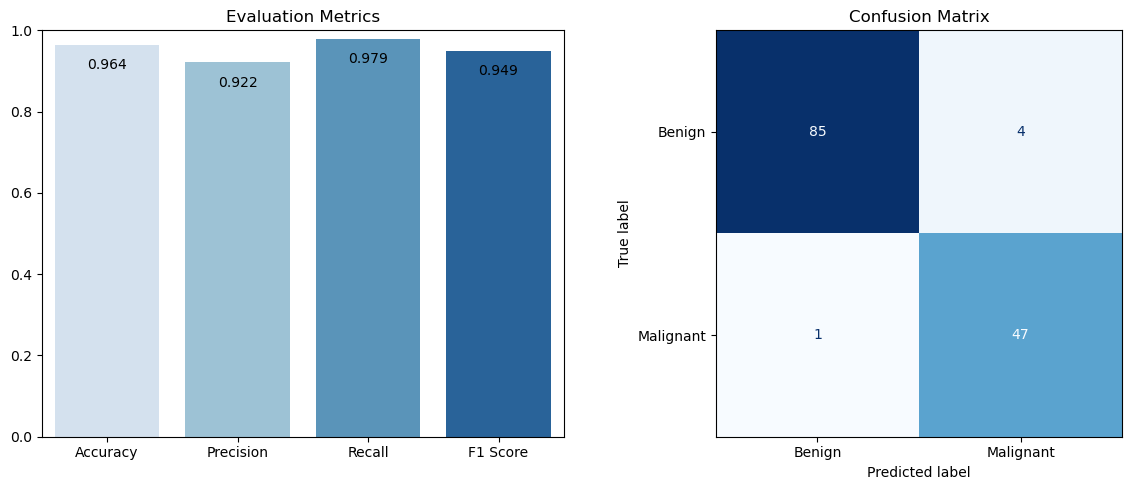

In [28]:
# Prediction
y_pred = best_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="binary", pos_label=1)
recall = recall_score(y_test, y_pred, average="binary", pos_label=1)
f1 = f1_score(y_test, y_pred, average="binary", pos_label=1)

metrics_dict = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

# Plot bar + confusion matrix side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
sns.barplot(
    x=list(metrics_dict.keys()),
    y=list(metrics_dict.values()),
    hue=list(metrics_dict.keys()),
    palette="Blues",
    ax=axes[0]
)
axes[0].set_ylim(0, 1)
axes[0].set_title("Evaluation Metrics")

for i, v in enumerate(metrics_dict.values()):
    axes[0].text(
        i, 
        v - 0.05,              
        f"{v:.3f}", 
        ha="center", 
        va="center", 
        fontsize=10,
        color="black",         
    )

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Benign", "Malignant"]
)
disp.plot(cmap="Blues", values_format="d", ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()